In [1]:
import pandas as pd
import matplotlib as plt
import numpy as np
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller
from numpy import log
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import acf

In [2]:
#função para tratar campo data
def parser(x):
    return pd.datetime.strptime('190'+x, '%Y-%m')

#Agora vamos importar nosso arquivo 
df = pd.read_excel('db_br.xlsx', sheet_name='Sheet1')
print(df.head(10))

   year  value     liter
0  2017  255.06   412770
1  2018  259.33   720236
2  2019  266.04  1330163
3  2020  267.16  2430153
4  2021  264.94  3296386
5  2022  291.40  4141401
6  2023  301.80  4419242


<Axes: xlabel='year'>

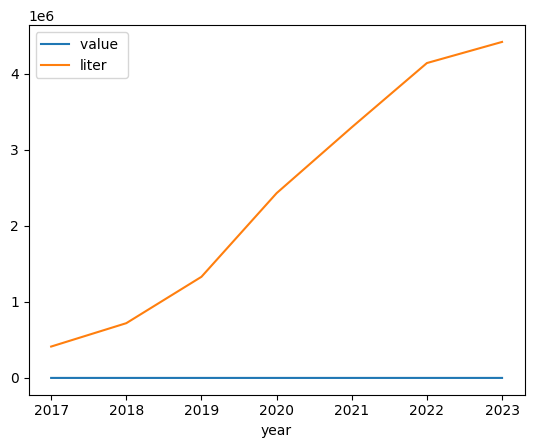

In [3]:
df.set_index('year', inplace=True)
df.plot()

Muito pouco dado, mas é possível ver que o conjunto de dados tem uma tendência clara.

Vamos também dar uma olhada rápida em um gráfico de autocorrelação da série temporal. Isso pode ser feito usando o Pandas. O exemplo abaixo plota a autocorrelação para um grande número de lags na série temporal.

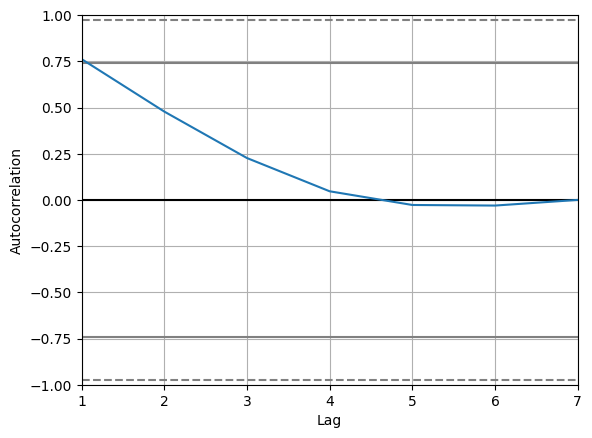

In [4]:
pd.plotting.autocorrelation_plot(df)
plt.pyplot.show()

Isso sugere que a série temporal não é estacionária e exigirá diferenciação para torná-la estacionária.

Para torná-la estacionária precisaremos diferencia-la.

O objetivo de diferenciá-lo para tornar a série temporal estacionária.

Mas você precisa ter cuidado para não superestimar a série. Por isso, uma série super diferenciada ainda pode ser estacionária, o que, por sua vez, afetará os parâmetros do modelo.

Então, como determinar a ordem correta de diferenciação?

A ordem correta da diferenciação é a diferenciação mínima necessária para obter uma série quase estacionária que circula em torno de uma média definida e o gráfico do ACF chega a zero razoavelmente rápido.

Se as autocorrelações forem positivas para muitos atrasos (10 ou mais), a série precisará ser diferenciada. Por outro lado, se a autocorrelação lag 1 em si for muito negativa, a série provavelmente será super diferenciada.

No caso, você não pode realmente decidir entre duas ordens de diferenciação e seguir a ordem que apresenta o menor desvio padrão na série diferenciada.

Vamos ver como fazer isso com um exemplo.

Primeiro, vou verificar se a série está estacionária usando o teste Augmented Dickey Fuller (adfuller ()), do pacote statsmodels.

Por quê?

Porque você precisa diferenciar apenas se a série não for estacionária. Senão, nenhuma diferenciação é necessária, ou seja, d = 0.

A hipótese nula do teste ADF é que a série temporal não é estacionária. Portanto, se o valor p do teste for menor que o nível de significância (0,05), você rejeita a hipótese nula e deduz que a série temporal é realmente estacionária.

Portanto, no nosso caso, se P Value> 0,05, prosseguimos em busca da ordem da diferenciação.

In [5]:
df.reset_index(inplace=True)
#df.set_index('value', inplace=True)
df.head(10)

,year,value,liter
0,2017,255.06,412770
1,2018,259.33,720236
2,2019,266.04,1330163
3,2020,267.16,2430153
4,2021,264.94,3296386
5,2022,291.40,4141401
6,2023,301.80,4419242


In [6]:
## Eliminar espacos dos nomes das colunas
df.columns = df.columns.str.strip()

In [7]:
df_new = df.drop(columns=['liter', 'year'])
df_new.head()

,value
0,255.06
1,259.33
2,266.04
3,267.16
4,264.94


In [8]:
result = adfuller(df_new.value.dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: 0.252438
p-value: 0.975054


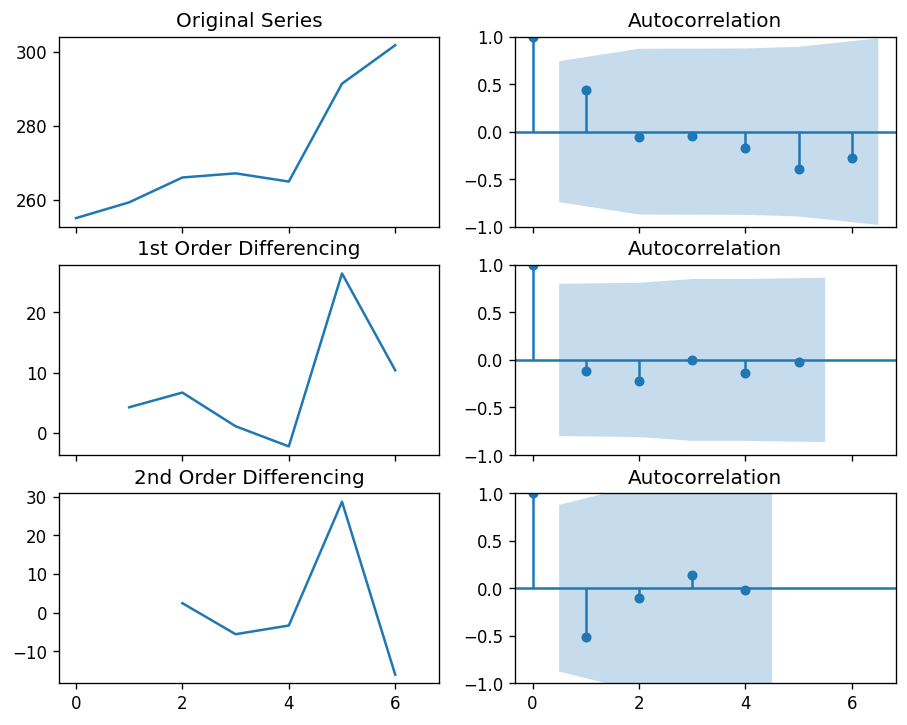

In [9]:
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})

# Importando dados
#df = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/wwwusage.csv', names=['value'], header=0)

# Série Original
fig, axes = plt.pyplot.subplots(3, 2, sharex=True)
axes[0, 0].plot(df.value); axes[0, 0].set_title('Original Series')
plot_acf(df.value, ax=axes[0, 1])

# 1st Diferenciação
axes[1, 0].plot(df.value.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(df.value.diff().dropna(), ax=axes[1, 1])

# 2nd Diferenciação
axes[2, 0].plot(df.value.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(df.value.diff().diff().dropna(), ax=axes[2, 1])

plt.pyplot.show()


Para as séries acima, a série temporal atinge a estacionariedade com duas ordens de diferenciação. Mas, olhando para o gráfico de autocorrelação para a segunda diferenciação do lag, entra na zona negativa muito rápido, o que indica que a série pode ter sido super diferenciada.

Então, tentarei fixar provisoriamente a ordem da diferenção como 1, mesmo que a série não seja perfeitamente estacionária (fraca estacionariedade).

## Como encontrar a ordem do termo AR (p)
A próxima etapa é identificar se o modelo precisa de termos de AR. Você pode descobrir o número necessário de termos de AR, inspecionando o gráfico PACF (Plot de correlação parcial).

Mas o que é PACF?

A autocorrelação parcial pode ser imaginada como a correlação entre a série e seu lag, após excluir as contribuições dos atrasos intermediários. Portanto, o PACF meio que transmite a correlação pura entre um lag e a série. Dessa forma, você saberá se esse lag é necessário no termo AR ou não.

Agora, como encontrar o número de termos de AR?

Qualquer autocorrelação em uma série estacionarizada pode ser retificada adicionando termos de AR suficientes. Portanto, inicialmente consideramos a ordem do termo AR igual a tantos lags que ultrapassam o limite de significância no gráfico PACF.

ValueError: Can only compute partial correlations for lags up to 50% of the sample size. The requested nlags 5 must be < 3.

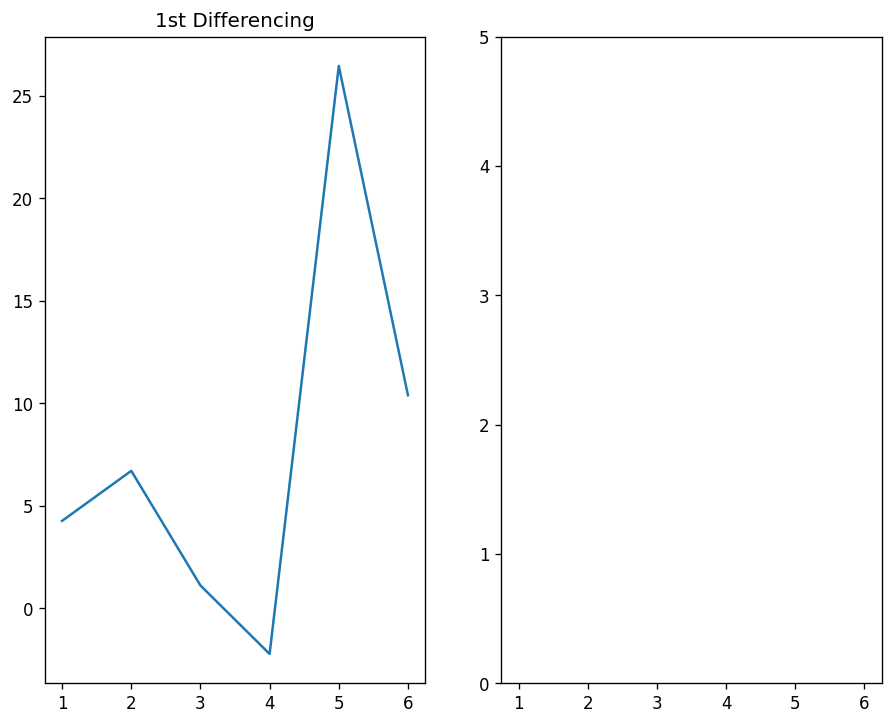

In [12]:
# PACF plot da serie diferenciada 1x

fig, axes = plt.pyplot.subplots(1, 2, sharex=True)
axes[0].plot(df.value.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,5))
plot_pacf(df.value.diff().dropna(), ax=axes[1])

plt.pyplot.show()

Você pode observar que o lag 1 do PACF é bastante significativo, pois está bem acima da linha de significância. O lag 2 também é significativo, conseguindo ultrapassar um pouco o limite de significância (região azul). Mas vou ser conservadora e, provisoriamente, corrigir o p como 1.

## Como encontrar a ordem do termo MA (q)
Assim como observamos o gráfico do PACF para o número de termos de AR, você pode ver o gráfico do ACF para o número de termos de MA. Um termo MA é tecnicamente o erro da previsão atrasada.

O ACF informa quantos termos de MA são necessários para remover qualquer autocorrelação na série estacionarizada.

Vamos ver o gráfico de autocorrelação das séries diferenciadas.

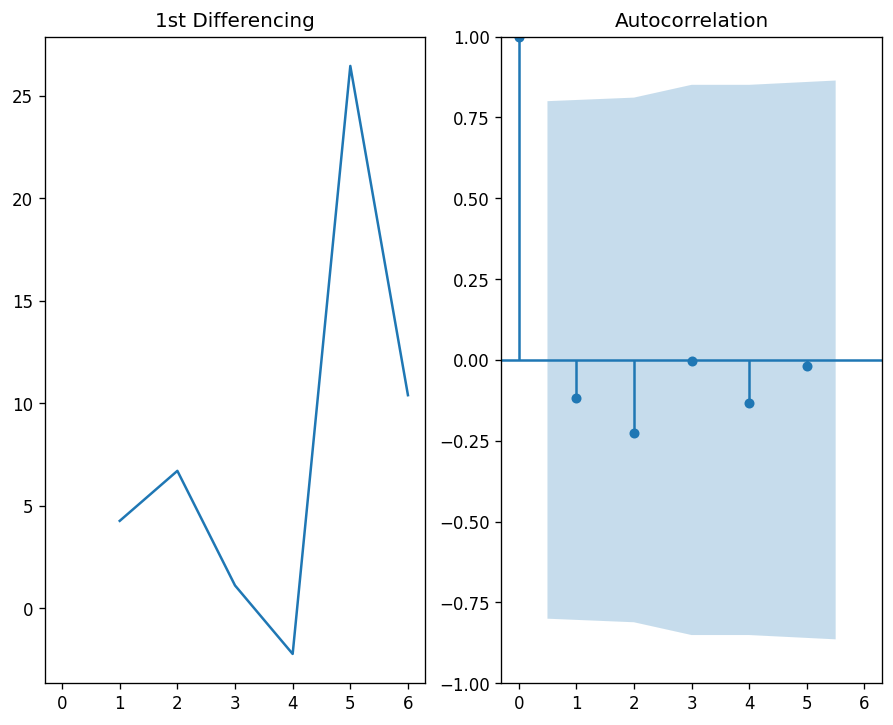

In [13]:
fig, axes = plt.pyplot.subplots(1, 2, sharex=True)
axes[0].plot(df.value.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,1.2))
plot_acf(df.value.diff().dropna(), ax=axes[1])

plt.pyplot.show()

Algumas defasagens estão bem acima da linha de significância. Então, vamos tentar usar provisoriamente q como 2. Em caso de dúvida, siga o modelo mais simples que explica suficientemente o Y.

## Como lidar se uma série temporal é um pouco abaixo ou acima da diferença
Pode acontecer que sua série esteja ligeiramente menos diferenciada, aonde diferenciá-la mais uma vez a torne um pouco super diferenciada.

Como lidar com este caso?

Se sua série estiver um pouco menos diferenciada, a adição de um ou mais termos adicionais de AR geralmente o fará. Da mesma forma, se houver um pouco de diferença excessiva, tente adicionar um termo MA adicional.

## Como construir o modelo ARIMA
Agora que você determinou os valores de p, d e q, você tem tudo o que é necessário para se ajustar ao modelo ARIMA. Vamos usar a implementação ARIMA () no pacote statsmodels

In [28]:

# 1,1,2 ARIMA Model

model = sm.tsa.arima.ARIMA(df.value, order=(2,1,2))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                    7
Model:                 ARIMA(2, 1, 2)   Log Likelihood                 -22.937
Date:                Fri, 15 Mar 2024   AIC                             55.875
Time:                        16:49:23   BIC                             54.834
Sample:                             0   HQIC                            51.707
                                  - 7                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2361      6.997      0.034      0.973     -13.478      13.950
ar.L2          0.7638      6.868      0.111      0.911     -12.697      14.224
ma.L1          0.0059    369.858   1.59e-05      1.0

C:\Users\crist\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\crist\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


O resumo do modelo revela muitas informações. A tabela no meio é a tabela de coeficientes em que os valores em "coef" são os pesos dos respectivos termos.

SE coeficiente do termo ma.L2 é próximo de zero e o valor P na coluna 'P> | z |' é altamente insignificante (próximo de 1). Idealmente, deveria ser menor que 0,05 para o respectivo X ser significativo.

Então, deveriamos reconstruir o modelo sem o termo MA2.


O modelo AIC reduziu, o que é bom. Os valores P dos termos AR1 e MA1 melhoraram e são altamente significativos (<< 0,05).

Vamos traçar os resíduos para garantir que não haja padrões (ou seja, procure média e variação constantes).

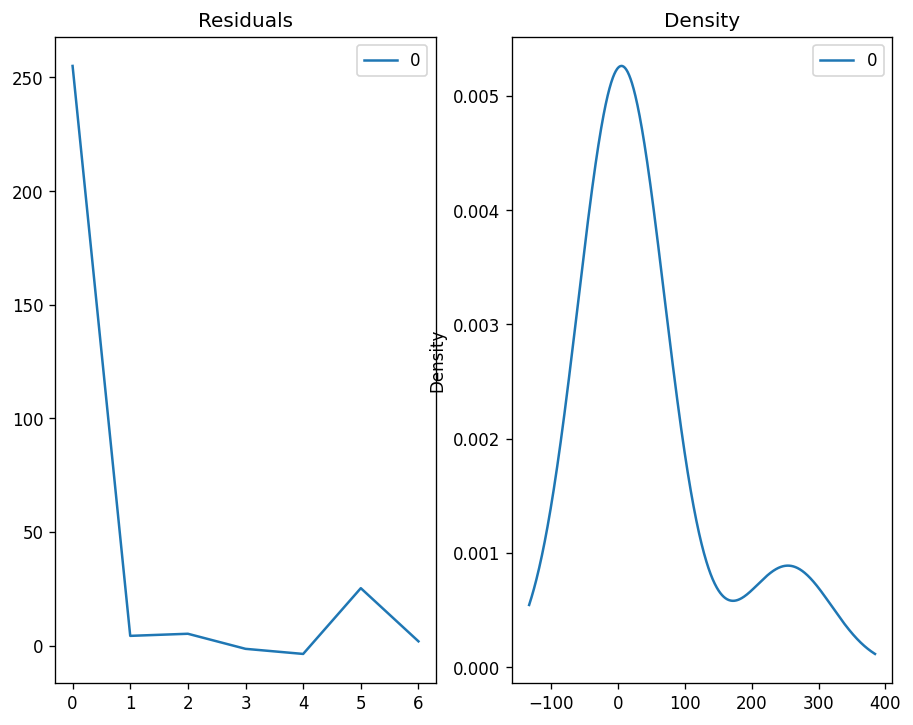

In [29]:
# Plot erro residual
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.pyplot.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.pyplot.show()

In [30]:
# Atual vs Previsto
fig = model_fit.predict(start =1, end=14, exog=None, dynamic=False)
fig

1     255.073096
2     260.857201
3     268.610477
4     268.634597
5     266.153991
6     299.951214
7     304.395709
8     311.414797
9     315.054350
10    321.274828
11    325.523177
12    331.277367
13    335.880660
14    341.362475
Name: predicted_mean, dtype: float64

1     382.59
2     263.60
3     267.87
4     272.14
5     276.41
6     280.68
7     284.95
8     289.22
9     293.49
10    297.76
11    302.03
12    306.30
13    310.57
14    314.84
Name: predicted_mean, dtype: float64

In [ ]:
# Atual vs Previsto
fig = model_fit.predict(start =1, end=14, exog=None, dynamic=False)
fig

NameError: name 'model_fit' is not defined

Quando você define dynamic = False, os valores lag na amostra são usados para previsão.

Ou seja, o modelo é treinado até o valor anterior para fazer a próxima previsão. Isso pode fazer com que a previsão e os dados reais pareçam artificialmente bons.

Portanto, parece que temos um modelo ARIMA decente. Mas esse é o melhor?

Não posso dizer isso neste momento, porque ainda não previmos o futuro e comparamos a previsão com o desempenho real.

Portanto, a validação real de que você precisa agora é a validação cruzada de Out-Time.

In [11]:
# Atual vs Previsto
fig = model_fit.predict(start =8, end=14, exog=None, dynamic=False)
fig

NameError: name 'model_fit' is not defined